In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,  accuracy_score, precision_score, recall_score, f1_score, classification_report

Virheanalyysi

In [2]:
# Kuvat:
train_path = os.path.sep.join(['histopathologic-cancer-detection','train'])
# Kuvatiedostojen nimet ja pohjatotuudet: 
data_path = os.path.sep.join(['histopathologic-cancer-detection'])
eval_data = pd.read_csv(data_path+'/eval_data.csv')
eval_data['id']=eval_data['id'].astype('string')
eval_data['label']=eval_data['label'].astype('string')

In [3]:
print(eval_data[:10])

                                             id label
0  0298c59aa8dafa0470470f94dccf859c51de3ebf.tif     0
1  fbf15afc5b05fec3494abeeeeaf0aaa59ce92486.tif     1
2  cbc2368ad58f6670d641bd93fcef2fa3c9f6e0e4.tif     0
3  43115bc989be642f5eee067982ed8c0693b09359.tif     1
4  c4a1e3931f7c182984ac3bf9c33f017af4d850ba.tif     1
5  1cded55c63aa8ffc61721d60f23e83d0979b94f0.tif     1
6  535508efadbf74491628bbc76977794814acac83.tif     1
7  0ac34a4ae8aac8e5fa1568ac7c4294736bdfbb1d.tif     0
8  64c7c40e903b8d543e5833ce0374d25007494bf3.tif     0
9  996d9c64f4893af98a6c88e532ed5cb0d7eecbf6.tif     1


In [4]:
# Haetaan malli:
models_path = os.path.sep.join(['gs_dnn_ensemble_20231210T1624', 'models'])
best_model_path = os.path.sep.join([models_path, '3_v1_89.097.hdf5'])
model = load_model(best_model_path)

In [5]:
# Evaluointi- tai testikuvat otetaan käyttöön:
def generator(data, path, mode):
    datagen_test = ImageDataGenerator(rescale=1./255)
    test_generator = datagen_test.flow_from_dataframe(
        dataframe=data,
        directory=path,
        target_size=(96, 96),
        batch_size=1,
        class_mode=mode,
        x_col='id',
        y_col='label',
        shuffle=False
    )
    return test_generator

In [6]:
# Ennustukset evaluointikuville:
eval_mode='binary'
eval_generator = generator(eval_data, train_path, eval_mode) 

eval_preds = model.predict(eval_generator, steps=len(eval_generator))
eval_preds_labels = (eval_preds > 0.5).astype(int)[:,0]

Found 77101 validated image filenames belonging to 2 classes.
77101/77101 [==============================] - 154s 2ms/step


In [7]:
print(f"Evaluoinnin tarkkuus {len(eval_generator.labels)} kappaleella: {np.mean(eval_preds_labels == eval_generator.labels)*100:.3f}")
print(eval_preds_labels)

Evaluoinnin tarkkuus 77101 kappaleella: 89.097
[1 1 0 ... 0 0 1]


In [8]:
gt_labels = eval_generator.labels
print('Pohjatotuus esimerkkejä:')
print(gt_labels[:10])

Pohjatotuus esimerkkejä:
[0, 1, 0, 1, 1, 1, 1, 0, 0, 1]


In [9]:
# Havainnollistetaan kuvien ennustettuja luokkia suhteessa pohjatotuuteen
cm = confusion_matrix(gt_labels, eval_preds_labels)
print(cm)

[[42727  2987]
 [ 5419 25968]]


In [10]:
print(eval_generator.class_indices)
classes = list(eval_generator.class_indices)

{'0': 0, '1': 1}


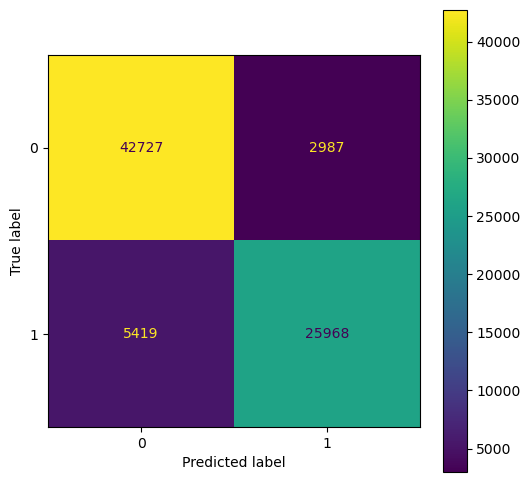

In [11]:
# Havainnollistetaan kuinka monta kuvaa ennustettu oikeaan ja väärään luokkaan
# Tehdään kuvaaja ja tallennetaan se hakemistoon:
filename='diagnostic_pics'
if not os.path.exists(filename):
        os.mkdir(filename)
    
fig, ax = plt.subplots(figsize=(6, 6))
# annetaan sekaannusmatriisi ja luokat displaylle
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(ax=ax)
fig.savefig(filename+'/gt_and_preds_distribution.png')

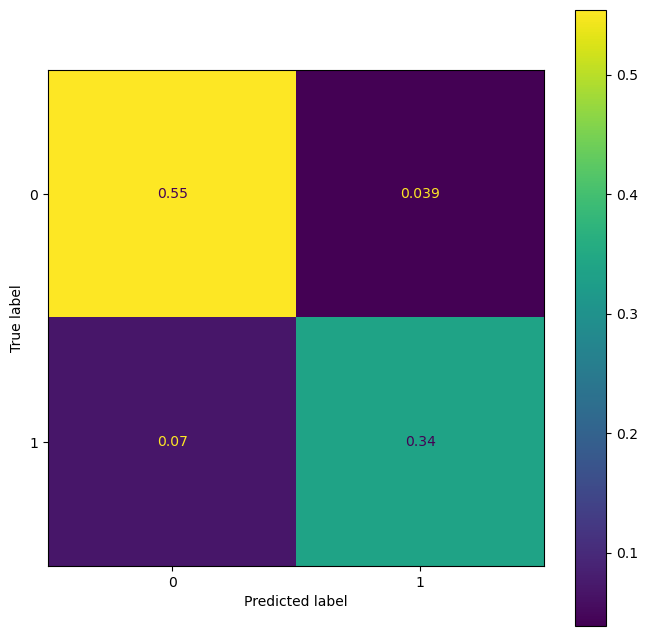

In [12]:
# Suhteelliset luokkamäärät
cm_norm = confusion_matrix(gt_labels, eval_preds_labels, normalize='all')
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=classes)
disp.plot(ax=ax)

In [13]:
# Tarkkuuksien tarkastelua
acc, prec, rec, fscore = accuracy_score(gt_labels, eval_preds_labels), precision_score(gt_labels, eval_preds_labels), \
                         recall_score(gt_labels, eval_preds_labels), f1_score(gt_labels, eval_preds_labels)

title = f'Classification results: \n ACC: {acc:.5f}, PREC: {prec:.5f}, REC: {rec:.5f}, FSCORE: {fscore:.5f} \n'
print(title, "\n", classification_report(gt_labels, eval_preds_labels, target_names=classes))

Classification results: 
 ACC: 0.89097, PREC: 0.89684, REC: 0.82735, FSCORE: 0.86069 
 
               precision    recall  f1-score   support

           0       0.89      0.93      0.91     45714
           1       0.90      0.83      0.86     31387

    accuracy                           0.89     77101
   macro avg       0.89      0.88      0.89     77101
weighted avg       0.89      0.89      0.89     77101



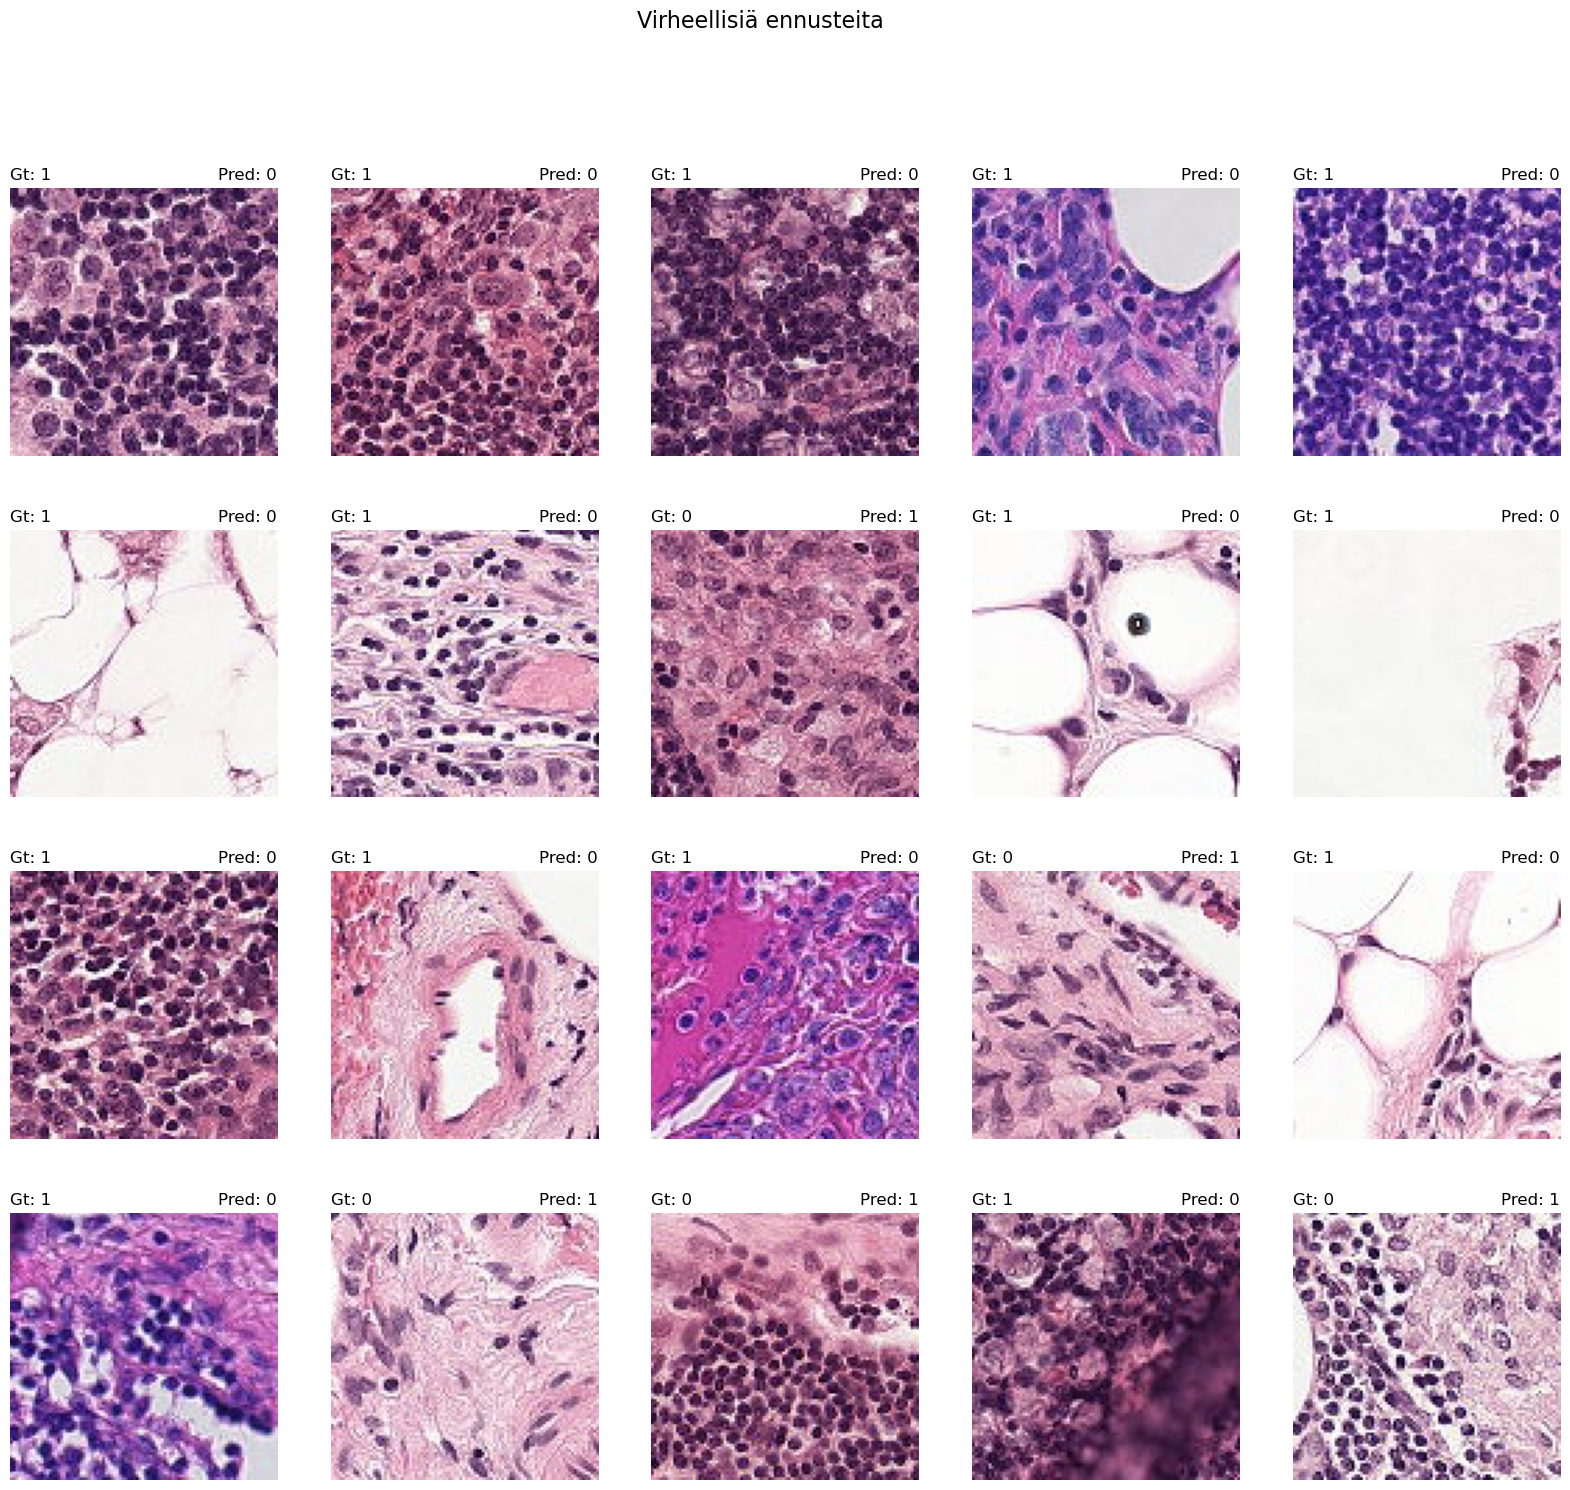

In [36]:
# Havainnollistetaan syöpä- ja normaalisolukkoa:

# Otetaan talteen pohjatotuudet ja indeksit, joissa on virheelliset ennustukset
gt=eval_generator.classes
misclassified_id = np.where(eval_preds_labels != gt )[0]
misclassified = np.random.choice(misclassified_id, 20)

# Esitetään kuva ja siihen liittyvä ennustus sekä pohjatotuus:
fig=plt.figure(figsize=(20, 17))
for i, id in enumerate(misclassified):
    img = load_img(eval_generator.filepaths[id])
    fig.add_subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(f"Gt: {gt[id]}", loc='left')
    plt.title(f"Pred: {eval_preds_labels[id]}", loc='right')
    plt.axis('off')
plt.suptitle("Virheellisiä ennusteita", fontsize=16)
plt.show()


fig.savefig(filename+'/misclassified_examples.png')







Ennustukset testidatalla, jolla ei ole pohjatotuuksia

In [37]:
# Kuvat:
test_path = os.path.sep.join(['histopathologic-cancer-detection','test'])
# Kuvatiedostojen nimet: 
test_data = pd.read_csv(data_path+'/test_data.csv')
test_data['id']=test_data['id'].astype('string')
test_data['label']=test_data['label'].astype('string')

In [38]:
print(test_data[:10])

                                             id label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif     0
1  95596b92e5066c5c52466c90b69ff089b39f2737.tif     0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914.tif     0
3  2c35657e312966e9294eac6841726ff3a748febf.tif     0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif     0
5  725dabe6ecccc68b958a2c7dd75bcbf362c7cb03.tif     0
6  aa0307865281d4484ddf8c637c348292968b93a7.tif     0
7  f4e5dc9c949920f1b3362982e15e99bf6f3ef83b.tif     0
8  95e08c9cedc28a9b4a86f4fc1e06c1972134be08.tif     0
9  ee1f5345a8d4e28403b7e61b97b5f76c201ce9cb.tif     0


In [40]:
# Tehdään testidatalle ennustukset:
test_mode='sparse'
test_generator = generator(test_data, test_path, test_mode) 

test_preds = model.predict(test_generator, steps=len(test_generator))
test_preds_labels = (test_preds > 0.5).astype(int)[:,0]

Found 57458 validated image filenames belonging to 1 classes.
57458/57458 [==============================] - 98s 2ms/step


In [41]:
test_preds_labels[:10]

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0])

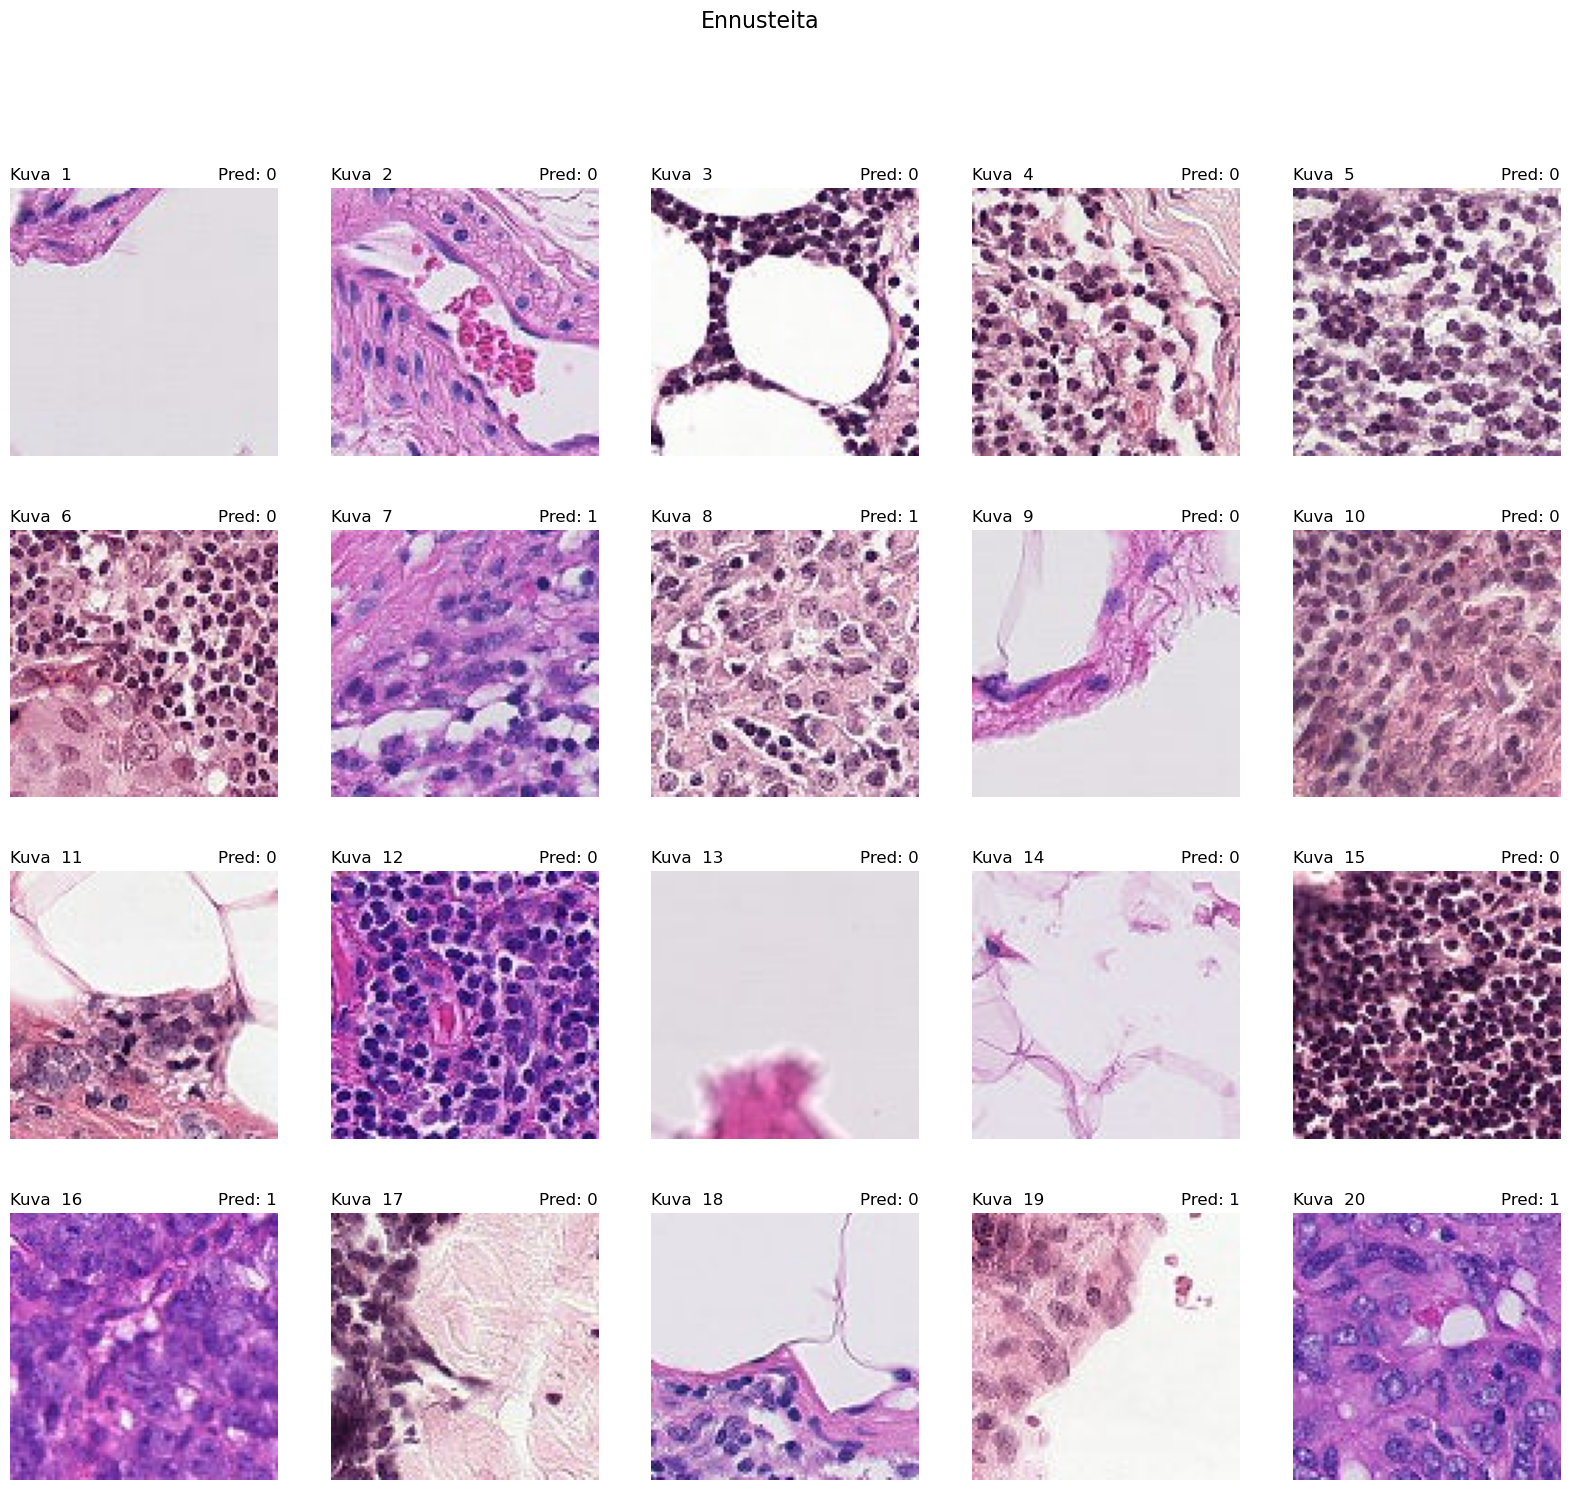

In [42]:
# Havainnollistetaan ennusteita ja tallennetaan kuva:

filename='unseen_prediction_pics'
if not os.path.exists(filename):
        os.mkdir(filename)
    

j=1
index=0
fig=plt.figure(figsize=(20, 17))
# Käydään läpi kuviennimen perusteella kuvia 
for pic_name in test_data['id'][:20]:
   img=load_img(test_generator.filepaths[index])
   fig.add_subplot(4, 5, j)
   plt.imshow(img)
   # Näkyviin kuvan saama ennuste
   plt.title(f"Pred: {test_preds_labels[index]}", loc='right')
   plt.title(f"Kuva  {j}", loc='left')
   plt.axis('off')
   index+=1
   j+=1
plt.suptitle("Ennusteita", fontsize=16)
plt.show()

fig.savefig(filename+'/preds_examples_unseentest.png')
            








In [43]:
filename='submission'
if not os.path.exists(filename):
        os.mkdir(filename)

# Tehdään Kaggleen palautettava csv-tiedosto, jossa kuviennimet ja niiden luokat 
submission_data = pd.read_csv(data_path+'/sample_submission.csv')
submission_data['label'] = test_preds_labels
submission_data.to_csv(filename+'/submission.csv', encoding='utf-8', index=False)